<a href="https://colab.research.google.com/github/DuyDucNguyen/Practical_FEM_FEniCS_Colab/blob/master/demo_poisson_solvers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo Poisson solvers 

In [0]:
# This program shows how to set built-in variable Parameter of Fenics and set solvers such as Newton solver or Krylov solver for Poisson equation

# Copyright (C) 2019 Duy Duc NGUYEN (duyduc.nguyen@protonmail.com)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2019-09-23
# Last changed: 2019-09-23

# This demo is maintained by Duy Duc NGUYEN
# Please report possible problems to duyduc.nguyen@protonmail.com

In [0]:
# install Fenics: 2 mins
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

fatal: destination path 'Practical_FEM_FEniCS_Colab' already exists and is not an empty directory.
>>> Call linear solver: GMRES <<<
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
>>> Call nonlinear solver: Newton <<<
>>> Call nonlinear solver: Newton-GMRES <<<


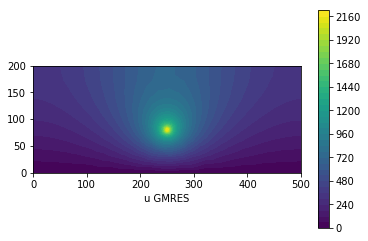

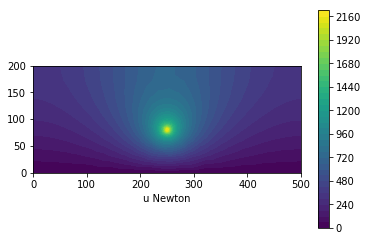

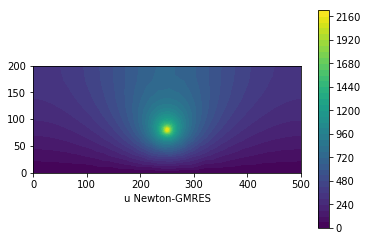

done


In [19]:
def Msh2Xml(mesh_name):
	import os
	print('>>> Converting mesh %s.msh into xml <<<' %(mesh_name))
	os.system("dolfin-convert %s.msh %s.xml" %(mesh_name, mesh_name))
	return


def buit_in_mesh():
	# Create mesh and define function space
	mesh = UnitSquareMesh(32, 32) 
	return mesh



def read_gmsh_mesh(filename = "rectangle.xml"):
	head, tail = filename.split('.')
	Msh2Xml(head)
	mesh = Mesh(filename)
	#plt.figure()
	#plot(mesh)
	#plt.show()
	return mesh



def xml2h5(filename = 'mesh.xml'):
	''' Description: Convert mesh written in XML format into H5 format
	    		 Write mesh tags (boundaries, domains) into H5 file
	    Input:  XML mesh
	    Output: H5 mesh
	'''
	head_name, tail_name = filename.split('.')
	mesh = Mesh(filename)                                                  
	cell_markers = MeshFunction("size_t", mesh, head_name + "_physical_region.xml")    
	facet_markers = MeshFunction("size_t", mesh, head_name + "_facet_region.xml")
	hdf = HDF5File(mesh.mpi_comm(), "mesh.h5", "w")
	hdf.write(mesh, "/mesh")
	hdf.write(cell_markers, "/cell_markers")
	hdf.write(facet_markers, "/facet_markers")
	#hdf.write(u, '/u')



def read_h5(filename = 'mesh.h5'):
	'''Description: Convert mesh written in XML format into H5 format
	   Write mesh tags (boundaries, domains) into H5 file
	   Input:  XML mesh
	   Output: H5 mesh
	'''
	mesh = Mesh()
	hdf = HDF5File(mesh.mpi_comm(), filename, "r")
	hdf.read(mesh, "/mesh", False)
	dim = mesh.topology().dim()
	cell_markers = MeshFunction("size_t", mesh, dim)
	hdf.read(cell_markers, "/cell_markers")
	facet_markers = MeshFunction("size_t", mesh, dim-1)
	hdf.read(facet_markers, "/facet_markers")
	return mesh, cell_markers, facet_markers



def check_geometry_h5(read_h5, filename = 'file.h5', plot_option = True):
	'''Description: Read H5 mesh file
	   Input: H5 mesh file
	   Output: facet markers and cell markers in PVD format 
	'''
	import os
	mesh, cell_markers, facet_markers = read_h5(filename)
	foldername = 'check_geometry_h5/'
	if os.path.isdir(foldername) == False:
		os.mkdir(foldername)
	File(foldername + "facet_markers.pvd") << facet_markers
	File(foldername + "cell_markers.pvd") << cell_markers
	if plot_option == True:
		plt.figure()
		plot(mesh)
		plt.show()
		plt.savefig('mesh')
	return


! git clone --recursive 'https://github.com/DuyDucNguyen/Practical_FEM_FEniCS_Colab/'
mesh_name = 'Practical_FEM_FEniCS_Colab/Geometry/2D_specimen_vacuum.h5'

# ================ Poisson ================
def poisson_problem(mesh_option ='h5'):
	if mesh_option == 'built-in':
		pass		

	if mesh_option == 'xml':
		mesh = Mesh('rectangle.xml')
		# Load GMSH boundary
		# Use MeshFunction to read GMSH-tags of Boundaries
		facet_markers = MeshFunction("size_t", mesh, "rectangle_facet_region.xml")
		# Use MeshFunction to read GMSH-tags of sub_domains
		cell_markers  = MeshFunction("size_t", mesh, "rectangle_physical_region.xml")

	if mesh_option == 'h5':
		mesh, cell_markers, facet_markers = read_h5(filename = mesh_name)
	
	V = FunctionSpace(mesh, "Lagrange", 1)
 
	# Define boundary condition
	u0 = Constant(0.0)
	dbc1 = DirichletBC(V, u0, facet_markers, 1) # interface
	dbc2 = DirichletBC(V, u0, facet_markers, 2)
	dbc3 = DirichletBC(V, u0, facet_markers, 3)
	dbc4 = DirichletBC(V, u0, facet_markers, 4)
	bc = [dbc4] # , dbc2, dbc3, dbc4

	
	# Measurement associated with the Interior domains
	dx = Measure('dx', domain=mesh, subdomain_data = cell_markers)

	# Measurement associated with the Exterior boundaries
	ds = Measure('ds', domain=mesh, subdomain_data = facet_markers)

	f = Expression("100*exp( -( pow(x[0] - 250.0, 2)/10.0 + pow(x[1] - 80.0, 2)/10.0 ) )", degree=1)
	g = Expression("sin(5*x[0])",degree=1)

	# Define variational problem
	du = TrialFunction(V)
	v = TestFunction(V)

	# For Linear problem
	a = inner(grad(du), grad(v))*dx
	L = f*v*dx #+ g*v*ds


	# For Non-Linear problem
	F = inner(grad(du), grad(v))*dx - f*v*dx #- g*v*ds

	return mesh, V, bc, a , L , F



# ================ Solvers ================

def high_level_linear_solver( a, L):
	solve(a == L, u, bc)
	return u



def high_level_nonlinear_solver( V, bc):
	solve(F == 0, u, bc)
	return u


def print_all_solvers():
	lap = parameters['linear_algebra_backend']
	print(list_linear_algebra_backends())
	
	print( "{}: all linear solvers".format(lap))
	print(list_linear_solver_methods())
	print( "{}: all krylov solvers".format(lap))
	print(list_krylov_solver_methods())
	print( "{}: all krylov preconditioners".format(lap))
	print(list_krylov_solver_preconditioners())



def print_solver_parameters():
	info(parameters, True)
	#File("parameters.xml") << parameters



def gmres_solver(V, bc, a, L,
		preconditioner = "hypre_euclid"
		):
	""" Description: linear solver GMRES 
		can not run in parallel
	"""
	print(">>> Call linear solver: GMRES <<<")
	u = Function(V)

	# define problem and solver
	problem = LinearVariationalProblem(a, L, u, bc)
	solver = LinearVariationalSolver(problem)

	# choose algorithms GMRES with ILU preconditioner
	solver.parameters['linear_solver'] = "gmres"
	solver.parameters['preconditioner'] = preconditioner  #ilu
	#solver.parameters['print_rhs'] = True

	# set local parameters
	prm = solver.parameters['krylov_solver'] # short form
	prm['absolute_tolerance'] = 1E-7
	prm['relative_tolerance'] = 1E-4
	prm['maximum_iterations'] = 1000
	prm['monitor_convergence'] = True
	prm['report'] = True

	#info(solver.parameters, True) 

	solver.solve()

	return u


def newton_solver(V, bc, F): 
	""" Description: Defind Newton algorithm
		can run in parallel
	"""
	print(">>> Call nonlinear solver: Newton <<<")
	du = TrialFunction(V)
	u = Function(V)	
	F  = action(F, u)

	# Jacobian matrix
	Jab = derivative(F, u, du)

	# set solver
	problem = NonlinearVariationalProblem(F, u, bc, Jab)	
	solver  = NonlinearVariationalSolver(problem)
	prm = solver.parameters

	prm['newton_solver']['absolute_tolerance'] = 1E-8
	prm['newton_solver']['relative_tolerance'] = 1E-7
	prm['newton_solver']['maximum_iterations'] = 25
	prm['newton_solver']['relaxation_parameter'] = 1.0
	
	#info(solver.parameters['newton_solver'], True)

	solver.solve()

	return u
	

	
def newton_gmres_solver(V, bc, F, 
			preconditioner = 'hypre_euclid'
			):
	""" Description: Defind Newton-GMRES algorithm
		can not run in parallel
	"""
	print(">>> Call nonlinear solver: Newton-GMRES <<<")
	du = TrialFunction(V)
	u = Function(V)	
	F  = action(F, u)

	# Jacobian matrix
	Jab = derivative(F, u, du)

	# set problem and solver
	problem = NonlinearVariationalProblem(F, u, bc, Jab)	
	solver  = NonlinearVariationalSolver(problem)
	prm = solver.parameters

	# set Newton solver
	prm['newton_solver']['absolute_tolerance'] = 1E-8
	prm['newton_solver']['relative_tolerance'] = 1E-7
	prm['newton_solver']['maximum_iterations'] = 50
	prm['newton_solver']['relaxation_parameter'] = 1.0	
	prm['newton_solver']['linear_solver'] = 'gmres'
	prm['newton_solver']['preconditioner'] = preconditioner 

	#info(prm['newton_solver'], True)

	# set GMRES solver
	prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-9
	prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-7
	prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
	
	#info(prm['newton_solver'], True)
	solver.solve()
	return u 


def mpi_commands():
	#dolfin-version 2018.1.0
	comm = MPI.comm_world
	mpi_rank = MPI.rank(comm) # rank of current processor
	mpi_size = MPI.size(comm) # total processors called
	print("Hello from process {} of total of {}".format(mpi_rank, mpi_size))


def log_level_options():
	print("""
	CRITICAL  = 50, // errors that may lead to data corruption and suchlike
	ERROR     = 40, // things that go boom
	WARNING   = 30, // things that may go boom later
	INFO      = 20, // information of general interest
	PROGRESS  = 16, // what's happening (broadly)
	TRACE     = 13, // what's happening (in detail)
	""")

	#set_log_level(LogLevel.CRITICAL)
	#set_log_level(LogLevel.ERROR)
	#set_log_level(LogLevel.WARNING)
	#set_log_level(LogLevel.INFO)
	#set_log_level(LogLevel.PROGRESS)
	#set_log_level(LogLevel.TRACE)
	#set_log_level(True)

	return 


# ================ Simulation ================

def solve_poisson_problem():
	mesh, V, bc, a , L , F = poisson_problem(mesh_option ='h5')
	all_pre = ["amg", "hypre_amg", "hypre_euclid", "hypre_parasail", "icc", "ilu", "jacobi", "none", "petsc_amg", "sor"]
	

	u1 = gmres_solver(V, bc, a, L, preconditioner = 'hypre_euclid')
	u2 = newton_solver(V, bc, F)
	u3 = newton_gmres_solver(V, bc, F, preconditioner = 'hypre_euclid')

	
	# Save solution in VTK format
	#file = File("paraview_files/" + "poisson.pvd")
	#file << u

	# Plot solutions
	plt.figure()
	p1=plot(u1)
	plt.xlabel('u GMRES')
	plt.colorbar(p1)
  
	plt.figure()
	p2=plot(u2)
	plt.xlabel('u Newton')
	plt.colorbar(p2)
  
	plt.figure()
	p3=plot(u3)
	plt.xlabel('u Newton-GMRES')
	plt.colorbar(p3)
  
	plt.show()
	#plt.savefig("u.png", bbox_inches='tight')
	


if __name__ == "__main__":
	# Disable these commands before run in parallel===
	#xml2h5(filename = 'rectangle.xml')
	#read_h5(filename = 'mesh.h5')
	#check_geometry_h5(read_h5, filename = 'mesh.h5')
	#=================================================


	# Print 'parameters'
	#parameters['linear_algebra_backend'] = 'PETSc'
	#print_all_solvers()

	#parameters['linear_algebra_backend'] = 'Eigen'
	#print_all_solvers()	
	#=================================================



	#print('\n Set krylov solver parameters \n')

	#prm = parameters['krylov_solver'] # short form
	#prm['absolute_tolerance'] = 1E-10
	#prm['relative_tolerance'] = 1E-6
	#prm['maximum_iterations'] = 1000
	#=================================================

	"""
	print dofs, cells, vertices
	"""

	solve_poisson_problem()


	print("done")





